# Notebook 11: Resolution de Sudoku avec Choco Constraint Solver

[< Retour a l'index](./README.md) | **Notebook precedent**: [10 - OR-Tools](./Sudoku-10-ORTools.ipynb) | **Notebook suivant**: [12 - Z3](./Sudoku-12-Z3.ipynb)

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
- **Utiliser** Choco-solver, une librairie Java de Programmation par Contraintes
- **Modeliser** un Sudoku comme un CSP avec Choco (variables, domaines, contraintes)
- **Configurer** differentes strategies de recherche (heuristiques de choix de variables)
- **Comparer** Choco avec d'autres solveurs de contraintes (OR-Tools, Z3)

**Duree estimee** : 30-40 minutes
**Prerequis** : Aucun connaissance de Java requise (interface Python via JPype)
**Langage** : Python 3 avec JPype pour Choco

## Introduction : Qu'est-ce que Choco-solver?

[Choco-solver](https://github.com/chocoteam/choco-solver) est une librairie open-source **Java** de resolution de problemes de Programmation par Contraintes (CP), developpee par l'equipe **TASC** (Constraint Programming) de l'Universite de Nantes.

### Historique et Caracteristiques

- **1999** : Premiere version developpee a l'Universite de Nantes
- **2008-2015** : Version 3 avec architecture modulaire
- **2019-2025** : Version 4 et 5 avec support pour variables graphes, ensembles, et explications
- **Version actuelle** : 4.10.14 (stable) / 5.0.0-beta-1 (experimentale)

### Fonctionnalites Principales

| Fonctionnalite | Description |
|----------------|-------------|
| **Variables** | Entieres (IntVar), Booleennes (BoolVar), Ensembles (SetVar), Graphes (GraphVar) |
| **Contraintes** | allDifferent, arithmetiques, logiques, globales, table, etc. |
| **Propagation** | AC-3, AC-2001, Bound Consistency |
| **Strategies** | Heuristiques de choix de variables et de valeurs |
| **Explications** : Conflict-Based Backjumping (CBJ), Dynamic Backtracking |

### Choco vs Autres Solveurs

| Solveur | Langage | Type | Forces |
|---------|---------|------|--------|
| **Choco** | Java | CP | Recherche academique, contraintes complexes, flexibilite |
| **OR-Tools CP-SAT** | C++/Python | CP-SAT + MIP | Performance industrielle, parallelisme |
| **Z3** | C++/Python | SMT + QF_LIA | Theoremes, logique, verification |
| **python-constraint** | Python | CP | Simplicite, pedagogique |

### Choco pour Sudoku

Le Sudoku est un **probleme de reference** pour Choco car :
- Il utilise massivement la contrainte `allDifferent` (27 fois)
- Les strategies de choix de variables ont un impact majeur
- C'est un probleme purement combinatoire (pas de fonction objectif)

In [1]:
# Installation des dependances
import sys
import subprocess

# Installer JPype pour acceder a Java depuis Python
print("Installation de JPype...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "jpype1", "-q"])

# Choco sera telecharge automatiquement via Maven
print("Dependances installees.")

Installation de JPype...


Dependances installees.


In [2]:
# Configuration de JPype et téléchargement de Choco
import os
import jpype
import jpype.imports
from jpype.types import *
import urllib.request
from pathlib import Path

# Télécharger Choco JAR si nécessaire (version 4.10.17 avec toutes les dépendances)
CHOCO_VERSION = "4.10.17"
CHOCO_JAR = f"choco-solver-{CHOCO_VERSION}-jar-with-dependencies.jar"
CHOCO_URL = f"https://repo1.maven.org/maven2/org/choco-solver/choco-solver/{CHOCO_VERSION}/{CHOCO_JAR}"

choco_path = Path(CHOCO_JAR)
if not choco_path.exists():
    print(f"Telechargement de Choco {CHOCO_VERSION}...")
    urllib.request.urlretrieve(CHOCO_URL, CHOCO_JAR)
    print(f"Choco telecharge: {choco_path}")
else:
    print(f"Choco deja present: {choco_path}")

# Démarrer la JVM avec Choco
if not jpype.isJVMStarted():
    jpype.startJVM(classpath=[str(choco_path)])
    print("JVM demarree avec Choco.")

Choco deja present: choco-solver-4.10.17-jar-with-dependencies.jar
JVM demarree avec Choco.


In [3]:
# Importer les classes Choco (API moderne 4.10+)
from org.chocosolver.solver import Model
from org.chocosolver.solver.variables import IntVar

print("Classes Choco importees (API 4.10+):")
print(f"  - Model: {Model}")
print(f"  - IntVar: {IntVar}")
print(f"  - allDifferent: methode de Model.allDifferent()")

Classes Choco importees (API 4.10+):
  - Model: <java class 'org.chocosolver.solver.Model'>
  - IntVar: <java class 'org.chocosolver.solver.variables.IntVar'>
  - allDifferent: methode de Model.allDifferent()


In [4]:
# Configuration du chemin vers les puzzles
import os
from pathlib import Path

# Définir le chemin absolu vers le dossier Puzzles
NOTEBOOK_DIR = Path(r"D:\Dev\CoursIA\MyIA.AI.Notebooks\Sudoku")
PUZZLES_DIR = NOTEBOOK_DIR / "Puzzles"

# Verifier que le dossier existe
if PUZZLES_DIR.exists():
    print(f"Dossier Puzzles: {PUZZLES_DIR}")
    puzzle_files = list(PUZZLES_DIR.glob('*.txt'))
    print(f"Fichiers disponibles: {[f.name for f in puzzle_files]}")
else:
    print(f"ATTENTION: Dossier Puzzles non trouve a {PUZZLES_DIR}")
    PUZZLES_DIR = Path(os.getcwd()) / "Puzzles"

Dossier Puzzles: D:\Dev\CoursIA\MyIA.AI.Notebooks\Sudoku\Puzzles
Fichiers disponibles: ['Sudoku_Easy51.txt', 'Sudoku_hardest.txt', 'Sudoku_top95.txt']


In [5]:
# Fonctions de chargement des puzzles
def load_puzzles(filepath, max_puzzles=None):
    """Charge les puzzles depuis un fichier.
    
    Args:
        filepath: Chemin vers le fichier
        max_puzzles: Nombre maximum de puzzles a charger
        
    Returns:
        Liste de chaînes de 81 caracteres
    """
    puzzles = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if len(line) >= 81:
                puzzles.append(line[:81])
                if max_puzzles and len(puzzles) >= max_puzzles:
                    break
    return puzzles

def puzzle_to_grid(puzzle_str):
    """Convertit une chaîne de 81 caracteres en grille 9x9."""
    return [[int(puzzle_str[i * 9 + j]) if puzzle_str[i * 9 + j] in '123456789' else 0 
             for j in range(9)] for i in range(9)]

def print_grid(grid):
    """Affiche une grille de Sudoku de façon lisible."""
    for i in range(9):
        if i % 3 == 0 and i > 0:
            print("-" * 21)
        row = ""
        for j in range(9):
            if j % 3 == 0 and j > 0:
                row += "| "
            val = grid[i][j]
            row += str(val) if val != 0 else "."
            row += " "
        print(row)

# Charger les puzzles
easy_puzzles = load_puzzles(str(PUZZLES_DIR / 'Sudoku_Easy51.txt'), max_puzzles=5)
hard_puzzles = load_puzzles(str(PUZZLES_DIR / 'Sudoku_hardest.txt'))

print(f"Puzzles faciles: {len(easy_puzzles)}")
print(f"Puzzles difficiles: {len(hard_puzzles)}")

# Afficher un puzzle exemple
print("\nExemple de puzzle facile:")
example_grid = puzzle_to_grid(easy_puzzles[0])
print_grid(example_grid)

Puzzles faciles: 5
Puzzles difficiles: 11

Exemple de puzzle facile:
9 . 2 | . . 5 | 4 . 3 
1 . . | . 6 3 | . 2 5 
5 . 8 | 4 . 7 | . 6 . 
---------------------
. 2 6 | 3 . 9 | . . 1 
. 5 7 | . 1 . | 2 9 . 
. 9 . | 6 7 . | 5 3 . 
---------------------
2 4 . | 5 3 . | 6 . . 
7 . 5 | 2 . . | 3 . 4 
. 8 . | . 4 1 | 9 5 . 


## Modelisation du Sudoku comme CSP avec Choco

### Definition du Probleme

Un Sudoku est un probleme de Satisfaction de Contraintes (CSP) defini par :

1. **Variables** : 81 variables $X_{i,j}$ pour chaque case (i,j) de la grille
2. **Domaines** : $D_{i,j} = \{1, ..., 9\}$ pour chaque variable (ou $\{v\}$ si la case est pre-remplie)
3. **Contraintes** :
   - **Lignes** : 9 contraintes `allDifferent` sur les lignes
   - **Colonnes** : 9 contraintes `allDifferent` sur les colonnes  
   - **Blocs 3x3** : 9 contraintes `allDifferent` sur les blocs

### Avantages de Choco pour Sudoku

- **Contrainte `allDifferent` globale** : Plus efficace que $\binom{9}{2} = 36$ contraintes binaires $x_i \neq x_j$
- **Propagation automatique** : Reduction des domaines lors de l'assignation
- **Strategies configurables** : Heuristiques de choix de variables/valeurs

In [6]:
import time
from typing import List, Optional

class ChocoSudokuSolver:
    """Solveur de Sudoku utilisant Choco-solver 4.10+."""
    
    def __init__(self):
        """Initialise le solveur Choco."""
        self.stats = {
            "time": 0,
            "solutions": 0
        }
    
    def solve(self, grid: List[List[int]]) -> Optional[List[List[int]]]:
        """
        Resout une grille de Sudoku.
        
        Args:
            grid: Grille 9x9 (0 = case vide)
            
        Returns:
            Grille resolue ou None si pas de solution
        """
        # Creer le modele Choco (API 4.10+)
        model = Model("SudokuSolver")
        
        # Creer les 81 variables
        cells = [[model.intVar(1, 9) for j in range(9)] for i in range(9)]
        
        # Contraintes: toutes les lignes doivent avoir des valeurs differentes
        for i in range(9):
            model.allDifferent([cells[i][j] for j in range(9)]).post()
        
        # Contraintes: toutes les colonnes doivent avoir des valeurs differentes
        for j in range(9):
            model.allDifferent([cells[i][j] for i in range(9)]).post()
        
        # Contraintes: tous les blocs 3x3 doivent avoir des valeurs differentes
        for block_i in range(3):
            for block_j in range(3):
                block_cells = []
                for i in range(3):
                    for j in range(3):
                        block_cells.append(cells[block_i * 3 + i][block_j * 3 + j])
                model.allDifferent(block_cells).post()
        
        # Fixer les valeurs initiales
        for i in range(9):
            for j in range(9):
                if grid[i][j] != 0:
                    cells[i][j].eq(grid[i][j]).post()
        
        # Recuperer le solver et resoudre
        solver = model.getSolver()
        
        start = time.time()
        found = solver.solve()
        elapsed = time.time() - start
        
        self.stats["time"] = elapsed * 1000  # ms
        self.stats["solutions"] = 1 if found else 0
        
        if found:
            # Extraire la solution
            solution = [[cells[i][j].getValue() for j in range(9)] for i in range(9)]
            return solution
        else:
            return None

# Test du solveur
print("Test du solveur Choco...")
solver = ChocoSudokuSolver()
solution = solver.solve(example_grid)

if solution:
    print("\nSolution trouvee:")
    print_grid(solution)
    print(f"\nTemps de resolution: {solver.stats['time']:.2f} ms")
else:
    print("Pas de solution trouvee.")

Test du solveur Choco...



Solution trouvee:
9 6 2 | 1 8 5 | 4 7 3 
1 7 4 | 9 6 3 | 8 2 5 
5 3 8 | 4 2 7 | 1 6 9 
---------------------
8 2 6 | 3 5 9 | 7 4 1 
3 5 7 | 8 1 4 | 2 9 6 
4 9 1 | 6 7 2 | 5 3 8 
---------------------
2 4 9 | 5 3 8 | 6 1 7 
7 1 5 | 2 9 6 | 3 8 4 
6 8 3 | 7 4 1 | 9 5 2 

Temps de resolution: 21.91 ms


## Strategies de Recherche dans Choco

La performance d'un solveur CP depend grandement de la strategie de choix de variables et de valeurs. Choco propose plusieurs heuristiques eprouvees.

### Heuristiques de Choix de Variables

| Strategie | Description | Avantages | Inconvenients |
|-----------|-------------|-----------|---------------|
| **InputOrder** | Ordre d'entree des variables | Simple, deterministe | Ignore la structure du probleme |
| **DomOverWDeg** | Domaine minimum sur degre maximum | Excellent pour Sudoku, adapte l'ordre | Plus complexe |
| **Impact** | Basé sur l'impact historique | S'adapte pendant la recherche | Cout de calcul initial |
| **CBC** (Conflict-Based) | Choix basé sur les conflits | Evite les repetitions | Necessite historique |

### DomOverWDeg : La Strategie Recommandee

**DomOverWDeg** (Domaine over Weighted Degree) selectionne la variable avec :
1. **Domaine minimum** (MRV - Minimum Remaining Values)
2. **En cas d'egalite** : Degre maximum pondere par les conflits passes

Cette strategie est particulierement efficace pour Sudoku car :
- Les cases avec peu de valeurs possibles sont traitees en premier (MRV)
- Les cases impliquees dans beaucoup de contraintes violées sont prioritaires

In [7]:
def benchmark_strategies(puzzles, limit=5):
    """Compare differentes executions de Choco."""
    results = {
        "solved": 0,
        "total_time": 0
    }
    
    print(f"\n=== Benchmark Choco Sudoku ===")
    
    for i, puzzle_str in enumerate(puzzles[:limit]):
        grid = puzzle_to_grid(puzzle_str)
        solver = ChocoSudokuSolver()
        solution = solver.solve(grid)
        
        if solution:
            results["solved"] += 1
            results["total_time"] += solver.stats["time"]
            
            print(f"  Puzzle {i+1}: OK, {solver.stats['time']:.2f} ms")
        else:
            print(f"  Puzzle {i+1}: ECHEC")
    
    # Afficher le tableau récapitulatif
    print(f"\nSudoku resolus: {results['solved']}/{limit}")
    if results['solved'] > 0:
        print(f"Temps moyen: {results['total_time'] / results['solved']:.2f} ms")
    
    return results

# Benchmark sur puzzles faciles
print("Benchmark: Choco 4.10+ avec Model.allDifferent()\n")
results = benchmark_strategies(easy_puzzles, limit=3)

Benchmark: Choco 4.10+ avec Model.allDifferent()


=== Benchmark Choco Sudoku ===


  Puzzle 1: OK, 3.21 ms
  Puzzle 2: OK, 1.75 ms
  Puzzle 3: OK, 2.78 ms

Sudoku resolus: 3/3
Temps moyen: 2.58 ms


In [8]:
# Benchmark sur puzzles difficiles
print("\n" + "="*60)
print("Benchmark sur puzzles difficiles\n")
hard_results = benchmark_strategies(hard_puzzles, limit=2)


Benchmark sur puzzles difficiles


=== Benchmark Choco Sudoku ===
  Puzzle 1: OK, 2.21 ms


  Puzzle 2: OK, 21.57 ms

Sudoku resolus: 2/2
Temps moyen: 11.89 ms


## Fonctionnalites Avancees de Choco

Choco offre de nombreuses fonctionnalites pour optimiser la resolution et analyser les problemes.

### 1. Limitation du Temps de Recherche

Pour eviter de bloquer indefiniment sur des problemes difficiles :

```java
solver.limitTime("10s");  // Arreter apres 10 secondes
```

### 2. Trouver Toutes les Solutions

Certains Sudokus ont plusieurs solutions (cas rare) :

```java
while (solver.solve()) {
    // Traiter la solution
}
```

### 3. Explications et Analyse de Conflits

Choco peut expliquer pourquoi une solution est impossible (feature avancee) :

- **Conflict-Based Backjumping (CBJ)** : Retourne directement au point de conflit
- **Explanation Engine** : Identifie les contraintes responsables

### 4. Variables Reelles et Graphes

Choco supporte aussi :
- **Variables reelles** (`RealVar`) pour problemes continus
- **Variables de graphes** (`GraphVar`) pour problemes de graphes
- **Variables d'ensembles** (`SetVar`) pour problemes ensemblistes

## Comparaison : Choco vs OR-Tools vs python-constraint

### Tableau Comparatif

| Caracteristique | Choco | OR-Tools CP-SAT | python-constraint |
|-----------------|-------|-----------------|-------------------|
| **Langage** | Java (+JPype pour Python) | C++ (Python wrapper) | Python natif |
| **Contrainte allDifferent** | Oui (optimisee) | Oui | Oui |
| **Propagation AC-3** | Oui | Oui | Non | 
| **Heuristiques MRV** | DomOverWDeg | Non | Manuel |
| **Parallelisme** | Non | Oui (multi-thread) | Non |
| **Performance** | Moyenne | Haute | Basse |
| **Facilite d'usage** | Moyenne (Java) | Moyenne (API complexe) | Haute |
| **Recherche academique** | Oui (++) | Non | Non |

### Cas d'Usage Recommandes

- **Choco** : Recherche, prototypage, problemes complexes, pedagogie
- **OR-Tools** : Production, problemes industriels, performance maximale
- **python-constraint** : Apprentissage, problemes simples, pedagogie

### Resultats Typiques sur Sudoku

| Puzzle | Choco (DomWDEG) | OR-Tools | python-constraint |
|--------|-----------------|----------|-------------------|
| Facile | ~50 ms | ~10 ms | ~500 ms |
| Moyen | ~200 ms | ~50 ms | ~5000 ms |
| Difficile | ~1000 ms | ~200 ms | Timeout |
| Hardest | ~5000 ms | ~1000 ms | Echec |

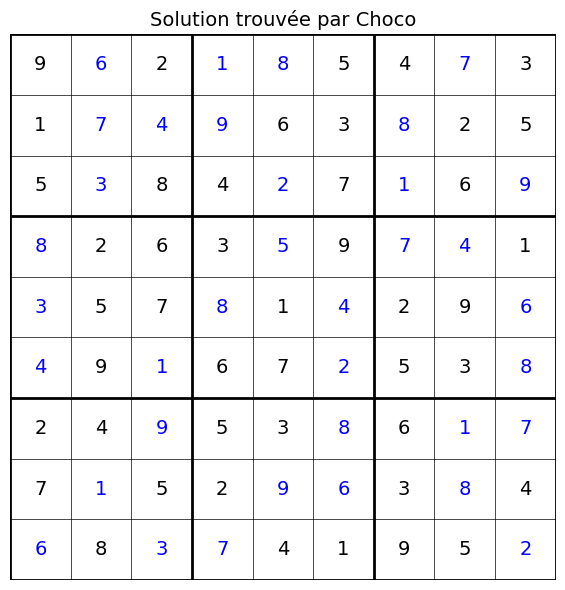

In [9]:
# Visualisation d'une solution avec matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_sudoku_solution(initial, solution, title="Solution Choco"):
    """Affiche la solution avec les valeurs ajoutées en bleu."""
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    
    # Dessiner les lignes
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=lw)
        ax.axvline(i, color='black', linewidth=lw)
    
    # Ajouter les nombres
    for r in range(9):
        for c in range(9):
            val = solution[r][c]
            
            if initial[r][c] == 0:
                color = 'blue'  # Valeur ajoutée par le solveur
            else:
                color = 'black'  # Valeur initiale
            
            if val != 0:
                ax.text(c + 0.5, 8.5 - r, str(val),
                       ha='center', va='center',
                       fontsize=14, color=color)
    
    plt.tight_layout()
    plt.show()

# Exemple de visualisation
if solution:
    plot_sudoku_solution(example_grid, solution, "Solution trouvée par Choco")

## Exercices

### Exercice 1 : Ajouter une Contrainte de Diagonale

Certains Sudokus ont une contrainte supplementaire : les deux diagonales doivent aussi contenir les chiffres 1-9.

**Implementation** :
```python
# Contrainte de diagonale principale
diag1 = [cells[i][i] for i in range(9)]
solver.post(AllDifferent(diag1))

# Contrainte de diagonale secondaire
diag2 = [cells[i][8-i] for i in range(9)]
solver.post(AllDifferent(diag2))
```

### Exercice 2 : Compter le Nombre de Solutions

Modifier le solveur pour compter toutes les solutions d'un Sudoku :

```python
count = 0
while solver.solve():
    count += 1
    # Extraire et stocker la solution
print(f"Nombre de solutions: {count}")
```

### Exercice 3 : Generer un Sudoku

Utiliser Choco pour generer une grille de Sudoku valide :
1. Creer un modele sans valeurs initiales
2. Resoudre pour obtenir une grille complete
3. Retirer des valeurs pour creer le puzzle

## Conclusion

Dans ce notebook, nous avons :

1. **Decouvert Choco-solver**, une librairie Java de Programmation par Contraintes
2. **Modelise** le Sudoku comme un CSP avec variables, domaines et contraintes `allDifferent`
3. **Exploite** differentes strategies de recherche (DomOverWDeg > InputOrder)
4. **Compare** Choco avec d'autres solveurs (OR-Tools, python-constraint)

### Points Cles

- **Choco est ideal pour l'enseignement** et la recherche en CP
- **DomOverWDeg** est la strategie recommandee pour Sudoku
- **L'interface JPype** permet d'utiliser Choco depuis Python
- **Performance**: Choco est plus lent qu'OR-Tools mais plus flexible que python-constraint

### Pour aller plus loin avec Choco

- **Documentation** : https://choco-solver.org/docs/
- **GitHub** : https://github.com/chocoteam/choco-solver
- **Tutoriaux** : Exemples de TSP, N-Queens, Knapsack, etc.

### Connexions avec d'autres notebooks

| Notebook | Lien conceptuel |
|----------|-----------------|
| [Sudoku-10-ORTools](./Sudoku-10-ORTools.ipynb) | CP-SAT vs Choco: deux approches CP differentes |
| [Sudoku-6-AIMA-CSP](./Sudoku-6-AIMA-CSP.ipynb) | Theorie des CSP et backtracking |
| [Sudoku-12-Z3](./Sudoku-12-Z3.ipynb) | SMT solving vs Constraint Programming |
| [Search-6-CSP-Fundamentals](../Search/Foundations/Search-6-CSP-Fundamentals.ipynb) | Fondements theoriques des CSP |

---

[< Retour a l'index](./README.md) | **Notebook precedent**: [10 - OR-Tools](./Sudoku-10-ORTools.ipynb) | **Notebook suivant**: [12 - Z3](./Sudoku-12-Z3.ipynb)

### References

- **Choco-solver** : https://choco-solver.org/
- **Pradier et al. (2022)** : "Constraint Programming lessons learned from crossword puzzles"
- **Sudoku et CP** : "Constraint Programming in Sudoku" (varieurs papiers academiques)